In [1]:
%config Completer.use_jedi = False
import warnings

warnings.filterwarnings(action='ignore')

# 오토 인코더(Auto Encoder)
오토 인코더는 신경망의 한 종류로 입력 데이터를 코드(Code)라고 부르는 은닉층으로, 인코딩하는 인코더(Encoder) 부분과 인코딩된 코드를 다시 디코딩하는 디코더(Decoder)로 구성되어 있다. 인코딩은 원래 데이터를 차원 축소하는 것을 의미하고, 디코딩은 차원 축소된 데이터를 다시 원래 데이터로 복원하는 것을 의미한다.

<br/>
<img src="images/autoEncoder_1.png" width="1200"/>

오토 인코더의 시작은 차원 축소와 관련이 있는데 초기 오토 인코더는 주성분 분석과 같은 차원 축소를 위해 오토 인코더를 사용했지만, 현재는 데이터 생성 모형으로도 쓰인다.

오토 인코더 실습
오토 인코더를 이용해 이미지 데이터의 노이즈를 없애본다.

In [2]:
# 동일한 결과를 보기 위해 랜덤 시드를 설정한다.
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# 데이터 불러오기, MNIST 데이터는 텐서플로우에서 제공하는 데이터셋이다.
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# 오리지널 데이터 차원 확인
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


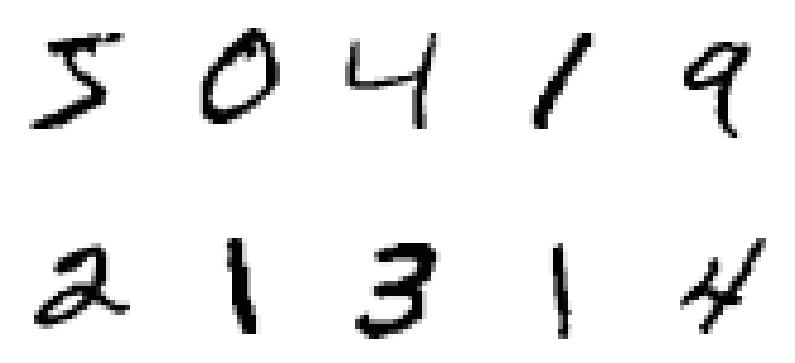

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [5]:
# 오리지날 데이터 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 서브 플롯을 설정한다.
    plt.imshow(X_train[i].reshape((28, 28)), cmap='Greys')  # i번째 손글씨 데이터를 시각화 한다.
    plt.axis(False)  # 축 레이블 감추기, plt.axis('off')
plt.show()
y_train[:10]

In [6]:
# 타겟 클래스 확인
# 타겟 데이터의 종류를 확인하면 손글씨를 어떤 형태로 구분하는지, 총 몇 가지 숫자를 구분하는지 알 수 있다.
# 결과를 확인하니 mnist 데이터는 0 부터 9까지 숫자를 구분하는 데이터임을 알 수 있다.
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [7]:
# 피처 데이터 스케일 조정
# 오리지널 데이터의 차원은 (이미지 개수, 행, 열) 형태의 3차원 형태로 표현했지만 합성곱 신경망에 데이터를 넣으려면
# 4차원 형태의 (이미지 개수, 행, 열, 채널 수) 형태로 구성해야 한다.
# 합성곱 신경망의 입력 데이터는 (이미지 개수, 행, 열, 채널 수) 형태로 구성된다. 이때, 채널이란 흔히 RGB로 구분되는
# 것을 의미하는데, 만약 하나의 이미지 데이터를 R을 이용한 픽셀값, G을 이용한 필셀값, B를 이용한 픽셀값으로 나타낼 때,
# 채널 수는 3이 된다. 하지만 딥러닝 분석에 사용되는 mnist 데이터는 채널 1개의 데이터이므로 채널 수는 1이 된다.
# 이미지 변형은 reshape() 함수를 이용해 (이미지 개수, 행, 열, 채널 수) 형태로 변경한다.
X_tn_re = X_train.reshape(60000, 28, 28, 1)  # 트레이닝 피쳐 데이터의 차원을 바꿔준다.
X_tn = X_tn_re / 255  # 이미지 픽셀값은 0 ~ 255 사이에 있으므로 최대값이 1이 되도록 조정한다.
print(X_tn.shape)
X_te_re = X_test.reshape(10000, 28, 28, 1)  # 테스트 피쳐 데이터의 차원을 바꿔준다.
X_te = X_te_re / 255
print(X_te.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
# 노이즈 피처 데이터
# 데이터셋에서 노이즈를 제공하지 않으므로, 직접 노이즈 데이터를 생성한다.
# 오리지널 트레이닝 데이터에 랜덤값을 더해준다. 랜덤값은 np.random.uniform() 함수로 균등 분포에서 추출한다.
# 랜덤값은 -1부터 1사이의 값을 가지며, 노이즈 배열의 크기는 트레이닝 데이터의 차원과 일치시켜 생성한다.
X_tn_noise = X_tn + np.random.uniform(-1, 1, size=X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1, 1, size=X_te.shape)

In [9]:
# 노이즈 데이터 스케일링
# 노이즈 데이터를 생성하는 과정에서 픽셀값이 0 이하 혹은 1 이상이 되었을 가능성이 있으므로 스케일을 조정한다.
# np.clip() 메서드를 사용하면 값의 범위를 조정할 수 있다.
X_tn_ns = np.clip(X_tn_noise, a_min=0, a_max=1)
X_te_ns = np.clip(X_te_noise, a_min=0, a_max=1)

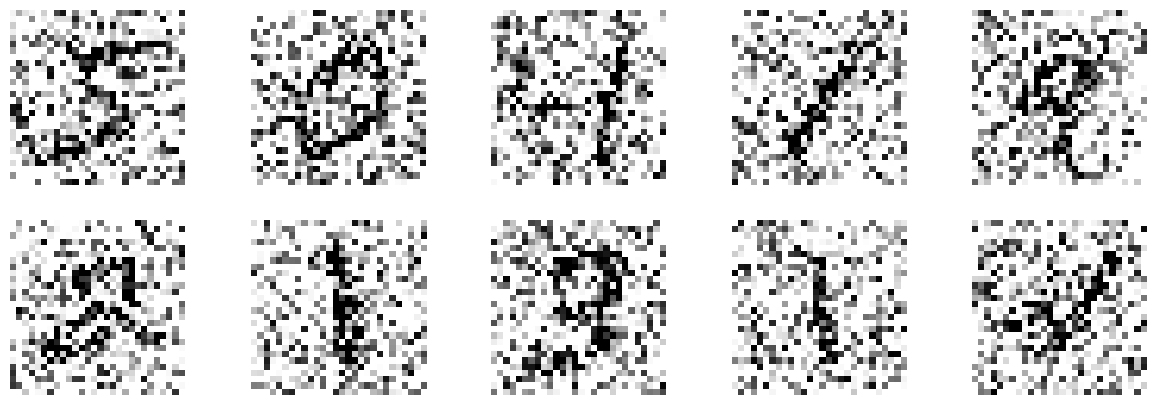

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [10]:
# 노이즈 데이터 시각화
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_tn_ns[i].reshape((28, 28)), cmap='Greys')
    plt.axis(False)
plt.show()
y_train[:10]

In [11]:
# 오토 인코더 신경망 생성에 필요한 라이브러리 import
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Activation, UpSampling2D

In [12]:
# 인코더 모형 생성
input_layer1 = Input(shape=(28, 28, 1))
x1 = Conv2D(filters=20, kernel_size=(5, 5), padding='same')(input_layer1)
# Param은 커널 크기(5 * 5) * 입력 채널(1) * 필터 크기(20) + 필터 당 바이어스(20) = 520
x1 = Activation(activation='relu')(x1)
output_layer1 = MaxPool2D(pool_size=(2, 2), padding='same')(x1)
encoder = Model(input_layer1, output_layer1)
encoder.summary()

Metal device set to: Apple M2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


2023-03-03 11:38:59.276502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-03 11:38:59.276978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# 인코더 출력 차원 확인
print(output_layer1.shape)
# 인코더 모형의 출력 차원을 확인해본다. 이는 디코더 모형의 입력 사이즈로 적용된다.
print(output_layer1.shape[1:4])

(None, 14, 14, 20)
(14, 14, 20)


In [14]:
# 디코더 모형 생성
# 디코더의 입력층을 설정한다. 디코더 모형의 입력층 데이터 차원은 인코더 모형의 출력 차원과 같다.
input_layer2 = Input(shape=output_layer1.shape[1:4])
x2 = Conv2D(filters=10, kernel_size=(5, 5), padding='same')(input_layer2)
# Param은 커널 크기(5 * 5) * 입력 채널(20) * 필터 크기(10) + 필터 당 바이어스(10) = 5010
x2 = Activation(activation='relu')(x2)
# 줄어든 차원을 다시 복원한다.
x2 = UpSampling2D()(x2)
# 최종 출력 채널의 개수는 최초 입력 이미지의 채널 수와 같아야 하므로 1로 설정한다.
x2 = Conv2D(filters=1, kernel_size=(5, 5), padding='same')(x2)
# Param은 커널 크기(5 * 5) * 입력 채널(10) * 필터 크기(1) + 필터 당 바이어스(1) = 251
output_layer2 = Activation(activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 14, 20)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 10)        5010      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 10)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         251       
                                                                 
 activation_2 (Activation)   (None, 28, 28, 1)         0         
                                                           

In [15]:
# 오토 인코더 모델 생성
# 오토 인코더는 최초의 입력값을 인코더에 먼저 넣고, 그 결과를 디코더에 넣은 결과이다.
input_auto = Input(shape=(28, 28, 1))  # 오토 인코더의 입력층 생성
output_auto = decoder(encoder(input_auto))  # 오토 인코더의 최종 출력층 생성
auto_encoder = Model(input_auto, output_auto)  # 오토 인코더 모델 생성
auto_encoder.summary()  # 오토 인코더 모델 요약

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 14, 14, 20)        520       
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         5261      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 모형 컴파일
from keras.optimizers import Adam

auto_encoder.compile(optimizer=Adam(lr=0.001), loss='mse')  # 오토 인코더 모델 컴파일

In [17]:
# 모형 학습
# 피쳐 데이터에는 노이즈가 추가된 x_tn_ns를 입력하고 타겟 데이터에는 노이즈가 없는 원본 트레이닝 데이터 x_train를 넣어 학습한다.
hist = auto_encoder.fit(X_tn_ns, X_tn, epochs=10, batch_size=100)  # 테스트 데이터 없이 학습
# hist = autoencoder.fit(X_tn_ns, X_tn, epochs=10, batch_size=100, validation_data=(X_te_ns, X_te))  # 테스트 데이터를 넣어 학습

Epoch 1/10


2023-03-03 11:38:59.886220: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-03 11:39:00.065697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


600/600 [==============================] - 9s 15ms/step - loss: 0.0268
Epoch 2/10
600/600 [==============================] - 9s 15ms/step - loss: 0.0216
Epoch 3/10
600/600 [==============================] - 9s 15ms/step - loss: 0.0204
Epoch 4/10
600/600 [==============================] - 9s 14ms/step - loss: 0.0187
Epoch 5/10
600/600 [==============================] - 9s 14ms/step - loss: 0.0165
Epoch 6/10
600/600 [==============================] - 9s 15ms/step - loss: 0.0154
Epoch 7/10
600/600 [==============================] - 9s 14ms/step - loss: 0.0147
Epoch 8/10
600/600 [==============================] - 9s 15ms/step - loss: 0.0143
Epoch 9/10
600/600 [==============================] - 8s 14ms/step - loss: 0.0139
Epoch 10/10
600/600 [==============================] - 8s 14ms/step - loss: 0.0137


In [18]:
# 학습한 모델로 예측
X_pred = auto_encoder.predict(X_tn_ns)

  46/1875 [..............................] - ETA: 6s

2023-03-03 11:40:28.223735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 7s 4ms/step


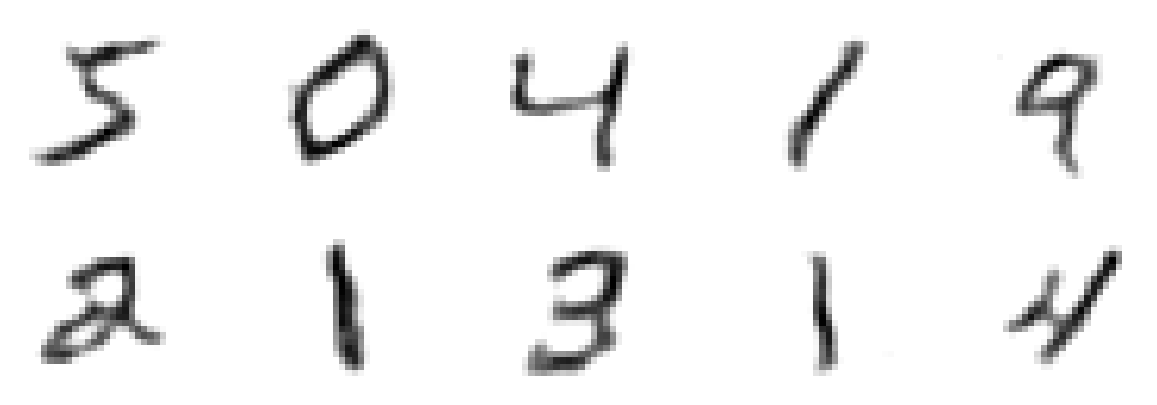

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [19]:
# 오토 인코딩 데이터 시각화
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_pred[i].reshape((28, 28)), cmap='Greys')
    plt.axis(False)
plt.show()
y_train[:10]